In [ ]:
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install tqdm
!pip install torch
!pip install tabulate


In [ ]:
pip install transformers==4.35.2 accelerate==0.23.0

In [38]:
from transformers import AutoConfig

In [1]:
# Ko-FinBERT + Active Learning 기반 ESG 뉴스 감성 분석 (1차 & 2차 파인튜닝 모두 epoch 7~10 테스트)

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
import glob
from tabulate import tabulate

# 공통 설정
model_name = "snunlp/KR-FinBert-SC"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is depre

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/143k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/294k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# 1. 함수

In [2]:
# 평가 지표 함수
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'eval_accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [3]:
# 지정한 epoch에 해당하는 모델을 평가 결과 CSV에서 찾아 로드하는 함수
def load_model_from_epoch(report_csv_path, epoch, device="cuda"):
    """
    지정한 epoch에 해당하는 모델을 평가 결과 CSV에서 찾아 로드하는 함수.

    Args:
        report_csv_path (str): train_with_epochs()에서 생성한 성능 CSV 경로
        epoch (int): 불러오고 싶은 epoch 번호
        device (str): 'cuda' 또는 'cpu'

    Returns:
        model: AutoModelForSequenceClassification 객체
    """
    df = pd.read_csv(report_csv_path)
    
    # 선택한 epoch에 해당하는 row 탐색
    row = df[df["epoch"] == epoch]
    if row.empty:
        raise ValueError(f"[ERROR] epoch {epoch}에 해당하는 모델이 없습니다. CSV 파일을 확인해주세요.")

    model_path = row["model_save_path"].values[0]
    print(f"[INFO] 🔍 모델 로딩: epoch {epoch} | 경로: {model_path}")

    # model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    return model_path

In [45]:
# 학습
def train_with_epochs(dataset, prefix):
    results = []
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    print(f"\n🔧 데이터 분할 완료: 학습 {len(dataset['train'])}개, 평가 {len(dataset['test'])}개")

    for epoch in [7, 8, 9, 10]:
        print(f"\n[INFO] 🔁 Training {prefix} with epoch={epoch}")
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to("cuda")
        # model 정의 바로 아래에 추가
        print("📦 분류기 구조:", model.classifier)
        print("🔧 num_labels 설정:", model.config.num_labels)
        training_args = TrainingArguments(
            output_dir=f"./{prefix}-epoch-{epoch}",
            learning_rate=5e-5,
            per_device_train_batch_size=12,
            gradient_accumulation_steps=1,
            num_train_epochs=epoch,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=False,
            save_total_limit=None,
            logging_steps=50,
            report_to="none",
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["test"],
            tokenizer=tokenizer,
            data_collator=DataCollatorWithPadding(tokenizer),
            compute_metrics=compute_metrics
        )

        trainer.train()
        print(f"[INFO] ✅ Epoch {epoch} 학습 완료")
        metrics = trainer.evaluate()
        print("📊 평가 지표 반환 결과:", metrics) 
        print(f"[INFO] 📊 Epoch {epoch} 평가 결과: {metrics}")
        metrics["epoch"] = epoch


        # checkpoint 디렉토리 중 가장 마지막으로 저장된 경로를 가져와 저장
        checkpoint_dirs = sorted(glob.glob(os.path.join(training_args.output_dir, "checkpoint-*")))
        if checkpoint_dirs:
            metrics["model_save_path"] = checkpoint_dirs[-1]
        else:
            metrics["model_save_path"] = "Not found"
        results.append(metrics)

        # ✅ epoch별 평가 지표 및 저장 위치 바로 출력
        print(f"[EPOCH {epoch}] Accuracy: {metrics['eval_accuracy']:.4f} | F1: {metrics['eval_f1']:.4f} | "
      f"Precision: {metrics['eval_precision']:.4f} | Recall: {metrics['eval_recall']:.4f}")
        print(f"[EPOCH {epoch}] 📁 Checkpoint 저장 경로: {metrics['model_save_path']}")

    results_df = pd.DataFrame(results)
    results_df.to_csv(f"{prefix}_epoch_performance_report.csv", index=False)
    
    # ✅ 전체 결과 요약 표로 출력
    print("\n📊 전체 epoch 성능 요약:")
    summary_table = results_df[["epoch", "eval_accuracy", "eval_f1", "eval_precision", "eval_recall", "model_save_path"]]
    print(tabulate(summary_table, headers="keys", tablefmt="github", showindex=False))
    print("\n📈 성능 그래프:")
    results_df.set_index("epoch")[["eval_accuracy", "eval_f1"]].plot(marker="o")
    plt.title(f"{prefix}: Epoch vs Accuracy/F1")
    plt.ylabel("Score")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.savefig(f"{prefix}_epoch_performance_plot.png")
    plt.show()

    print(f"\n✅ {prefix} 학습완료! 원하는 epoch의 모델을 선택하여 사용하세요.")
    print(f"🔎 결과 요약 파일: {prefix}_epoch_performance_report.csv")
    

# 2. 1차 파인튜닝

### 2-1. epoch 테스트

[STEP 1] 1차 라벨링 데이터 로딩 및 학습


Map:   0%|          | 0/2378 [00:00<?, ? examples/s]


🔧 데이터 분할 완료: 학습 1902개, 평가 476개

[INFO] 🔁 Training round1 with epoch=1


/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.717900,0.676281,0.670168,0.659306,0.684088,0.670168


[INFO] ✅ Epoch 1 학습 완료


📊 평가 지표 반환 결과: {'eval_accuracy': 0.6701680672268907, 'eval_loss': 0.6762813329696655, 'eval_f1': 0.659306249674895, 'eval_precision': 0.684087922941033, 'eval_recall': 0.6701680672268907, 'eval_runtime': 0.6478, 'eval_samples_per_second': 734.744, 'eval_steps_per_second': 92.615, 'epoch': 1.0}
[INFO] 📊 Epoch 1 평가 결과: {'eval_accuracy': 0.6701680672268907, 'eval_loss': 0.6762813329696655, 'eval_f1': 0.659306249674895, 'eval_precision': 0.684087922941033, 'eval_recall': 0.6701680672268907, 'eval_runtime': 0.6478, 'eval_samples_per_second': 734.744, 'eval_steps_per_second': 92.615, 'epoch': 1.0}
[EPOCH 1] Accuracy: 0.6702 | F1: 0.6593 | Precision: 0.6841 | Recall: 0.6702
[EPOCH 1] 📁 Checkpoint 저장 경로: ./round1-epoch-1/checkpoint-159

[INFO] 🔁 Training round1 with epoch=2


/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.703300,0.626375,0.733193,0.730800,0.734542,0.733193
2,0.462100,0.677059,0.714286,0.711131,0.715256,0.714286


[INFO] ✅ Epoch 2 학습 완료


📊 평가 지표 반환 결과: {'eval_accuracy': 0.7142857142857143, 'eval_loss': 0.6770592927932739, 'eval_f1': 0.7111313118408462, 'eval_precision': 0.7152560030676074, 'eval_recall': 0.7142857142857143, 'eval_runtime': 0.6359, 'eval_samples_per_second': 748.489, 'eval_steps_per_second': 94.347, 'epoch': 2.0}
[INFO] 📊 Epoch 2 평가 결과: {'eval_accuracy': 0.7142857142857143, 'eval_loss': 0.6770592927932739, 'eval_f1': 0.7111313118408462, 'eval_precision': 0.7152560030676074, 'eval_recall': 0.7142857142857143, 'eval_runtime': 0.6359, 'eval_samples_per_second': 748.489, 'eval_steps_per_second': 94.347, 'epoch': 2.0}
[EPOCH 2] Accuracy: 0.7143 | F1: 0.7111 | Precision: 0.7153 | Recall: 0.7143
[EPOCH 2] 📁 Checkpoint 저장 경로: ./round1-epoch-2/checkpoint-318

[INFO] 🔁 Training round1 with epoch=3


/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.705100,0.623966,0.737395,0.735455,0.738186,0.737395
2,0.460500,0.729270,0.695378,0.686341,0.704858,0.695378
3,0.190100,1.043670,0.697479,0.692617,0.705985,0.697479


[INFO] ✅ Epoch 3 학습 완료


📊 평가 지표 반환 결과: {'eval_accuracy': 0.6974789915966386, 'eval_loss': 1.043670415878296, 'eval_f1': 0.6926165906370801, 'eval_precision': 0.7059852403398477, 'eval_recall': 0.6974789915966386, 'eval_runtime': 0.6375, 'eval_samples_per_second': 746.663, 'eval_steps_per_second': 94.117, 'epoch': 3.0}
[INFO] 📊 Epoch 3 평가 결과: {'eval_accuracy': 0.6974789915966386, 'eval_loss': 1.043670415878296, 'eval_f1': 0.6926165906370801, 'eval_precision': 0.7059852403398477, 'eval_recall': 0.6974789915966386, 'eval_runtime': 0.6375, 'eval_samples_per_second': 746.663, 'eval_steps_per_second': 94.117, 'epoch': 3.0}
[EPOCH 3] Accuracy: 0.6975 | F1: 0.6926 | Precision: 0.7060 | Recall: 0.6975
[EPOCH 3] 📁 Checkpoint 저장 경로: ./round1-epoch-3/checkpoint-477

📊 전체 epoch 성능 요약:
|   epoch |   eval_accuracy |   eval_f1 |   eval_precision |   eval_recall | model_save_path                 |
|---------|-----------------|-----------|------------------|---------------|---------------------------------|
|       1 |        

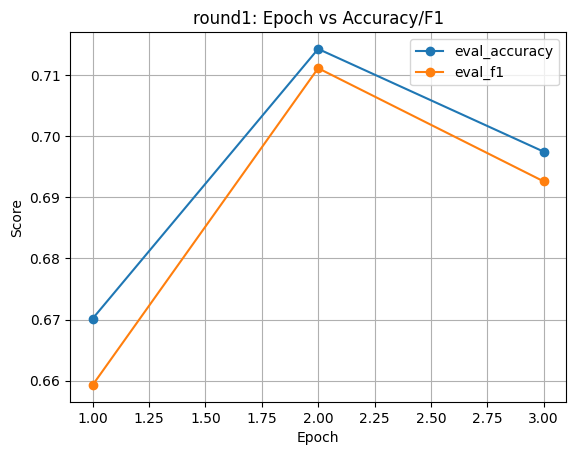


✅ round1 학습완료! 원하는 epoch의 모델을 선택하여 사용하세요.
🔎 결과 요약 파일: round1_epoch_performance_report.csv

📍 학습 완료! 'round1_epoch_performance_report.csv' 확인 후 원하는 epoch 모델을 선택하세요.


In [11]:
# 1. 수작업 라벨링 데이터 로드 → 1차 파인튜닝
print("[STEP 1] 1차 라벨링 데이터 로딩 및 학습")
labeled1 = pd.read_csv("labeled_esg_news_round1.csv")
dataset1 = Dataset.from_pandas(labeled1)
dataset1 = dataset1.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True)
train_with_epochs(dataset1, "round1")

print("\n📍 학습 완료! 'round1_epoch_performance_report.csv' 확인 후 원하는 epoch 모델을 선택하세요.")


### 2-2. 모델 선택 -> 라벨링 수행

In [12]:
# 사용자가 직접 선택한 epoch 값 입력
chosen_epoch = 2

# 모델 불러오기
model_path1 = load_model_from_epoch("round1_epoch_performance_report.csv", chosen_epoch)

[INFO] 🔍 모델 로딩: epoch 2 | 경로: ./round1-epoch-2/checkpoint-318


# 3.Margin Sampling 추출

In [14]:
# 2. 전체 예측 후 Margin Sampling → 2차 라벨링 대상 선정
print("\n[STEP 2] 전체 예측 및 Margin Sampling")
def get_predictions(model_path, text_list, batch_size=64):
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to("cuda")
    model.eval()
    all_probs = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        encodings = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
        with torch.no_grad():
            outputs = model(**encodings)
            probs = torch.softmax(outputs.logits, dim=-1)
            all_probs.extend(probs.cpu().numpy())
    return np.array(all_probs)

def margin_sampling(probs, top_k=500):
    margins = []
    for i, p in enumerate(probs):
        sorted_p = np.sort(p)
        margin = sorted_p[-1] - sorted_p[-2]
        margins.append((i, margin))
    selected = sorted(margins, key=lambda x: x[1])[:top_k]
    return [i for i, _ in selected]

unlabeled_df = pd.read_csv("unlabeled_esg_news.csv")
unlabeled_texts = unlabeled_df["text"].tolist()
probs = get_predictions(model_path1, unlabeled_texts)
selected_idxs = margin_sampling(probs, top_k=500)
to_label_texts = [unlabeled_texts[i] for i in selected_idxs]
pd.DataFrame({"text": to_label_texts}).to_csv("to_label_round2.csv", index=False)
print("✅ 2차 라벨링 대상 저장 완료: to_label_round2.csv")


[STEP 2] 전체 예측 및 Margin Sampling
✅ 2차 라벨링 대상 저장 완료: to_label_round2.csv


# <<<<수작업 2차 레이블링 진행>>>>

# 4. 데이터 통합

In [51]:
print("\n[STEP 3] 2차 라벨링 데이터 로딩 및 통합 학습")
labeled2 = pd.read_csv("labeled_esg_news_round2.csv")
combined = pd.concat([labeled1, labeled2], ignore_index=True)
combined = combined.drop_duplicates(subset=["text"])
combined["label"] = combined["label"].astype(int)
dataset2 = Dataset.from_pandas(combined)
print(f"🔢 통합 라벨링 데이터 수: {len(combined)}")


[STEP 3] 2차 라벨링 데이터 로딩 및 통합 학습
🔢 통합 라벨링 데이터 수: 2740


In [50]:
dataset2 = dataset2.rename_column("label", "labels")

# 5. 2차 파인튜닝

In [54]:
# ✅ Round2용 수정 사항 요약
# 1. 모델 로드시 AutoConfig 사용하여 구조 명시적으로 설정
# 2. trainer.train() 전에 classifier 구조 및 num_labels 출력
# 3. 'label' 컬럼을 'labels'로 rename 필요 (Trainer는 'labels'를 기본으로 사용함)
# 학습 함수
from transformers import AutoConfig, AutoModelForSequenceClassification
import os

def train_with_epochs(dataset, prefix, model_checkpoint):
    results = []

    # ✅ 1. 'label' → 'labels' 변경 (Trainer 기본 라벨 키)
    # if 'label' in dataset.column_names:
    #     dataset = dataset.rename_column("label", "labels")

    # ✅ 2. 데이터 분할
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    print(f"\n🔧 데이터 분할 완료: 학습 {len(dataset['train'])}개, 평가 {len(dataset['test'])}개")

    # os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# print("📦 classifier 확인:", model.classifier)
    for epoch in [7, 8, 9, 10]:
        print(f"\n[INFO] 🔁 Training {prefix} with epoch={epoch}")

        # ✅ 3. config 방식으로 모델 구조 명확히 설정
        config = AutoConfig.from_pretrained(model_checkpoint, num_labels=3)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_checkpoint,
            config=config
        ).to("cuda")

        # ✅ 4. 구조 디버깅 출력
        print("📦 분류기 구조:", model.classifier)
        print("🔧 num_labels 설정:", model.config.num_labels)

        training_args = TrainingArguments(
            output_dir=f"./{prefix}-epoch-{epoch}",
            learning_rate=5e-5,
            per_device_train_batch_size=12,
            gradient_accumulation_steps=1,
            num_train_epochs=epoch,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=False,
            save_total_limit=None,
            logging_steps=50,
            report_to="none",
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["test"],
            tokenizer=tokenizer,
            data_collator=DataCollatorWithPadding(tokenizer),
            compute_metrics=compute_metrics
        )

        trainer.train()
        print(f"[INFO] ✅ Epoch {epoch} 학습 완료")
        metrics = trainer.evaluate()
        print("📊 평가 지표 반환 결과:", metrics) 
        print(f"[INFO] 📊 Epoch {epoch} 평가 결과: {metrics}")
        metrics["epoch"] = epoch

        checkpoint_dirs = sorted(glob.glob(os.path.join(training_args.output_dir, "checkpoint-*")))
        if checkpoint_dirs:
            metrics["model_save_path"] = checkpoint_dirs[-1]
        else:
            metrics["model_save_path"] = "Not found"
        results.append(metrics)

        print(f"[EPOCH {epoch}] Accuracy: {metrics['eval_accuracy']:.4f} | F1: {metrics['eval_f1']:.4f} | "
              f"Precision: {metrics['eval_precision']:.4f} | Recall: {metrics['eval_recall']:.4f}")
        print(f"[EPOCH {epoch}] 📁 Checkpoint 저장 경로: {metrics['model_save_path']}")

    results_df = pd.DataFrame(results)
    results_df.to_csv(f"{prefix}_epoch_performance_report.csv", index=False)

    print("\n📊 전체 epoch 성능 요약:")
    summary_table = results_df[["epoch", "eval_accuracy", "eval_f1", "eval_precision", "eval_recall", "model_save_path"]]
    print(tabulate(summary_table, headers="keys", tablefmt="github", showindex=False))

    print("\n📈 성능 그래프:")
    results_df.set_index("epoch")[["eval_accuracy", "eval_f1"]].plot(marker="o")
    plt.title(f"{prefix}: Epoch vs Accuracy/F1")
    plt.ylabel("Score")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.savefig(f"{prefix}_epoch_performance_plot.png")
    plt.show()

    print(f"\n✅ {prefix} 학습완료! 원하는 epoch의 모델을 선택하여 사용하세요.")
    print(f"🔎 결과 요약 파일: {prefix}_epoch_performance_report.csv")


### 5-1. Epoch 평가

In [56]:
dataset2 = dataset2.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True)
train_with_epochs(dataset2, "round2", "./round1-epoch-1/checkpoint-159")

print("\n📍 학습 완료! 'round2_epoch_performance_report.csv'를 확인 후 원하는 모델을 선택하세요.")

Map:   0%|          | 0/2740 [00:00<?, ? examples/s]


🔧 데이터 분할 완료: 학습 2192개, 평가 548개

[INFO] 🔁 Training round2 with epoch=7


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### 5-2. 모델 선택

In [27]:
# 사용자가 직접 선택한 epoch 값 입력
chosen_epoch = 10

# 모델 불러오기
model_path2 = load_model_from_epoch("round2_epoch_performance_report.csv", chosen_epoch)

[INFO] 🔍 모델 로딩: epoch 10 | 경로: ./round2-epoch-10/checkpoint-8


# 6. 감성분석

In [ ]:
# 데이터 로드
print("\n[STEP 4] 최종 감성분석 실행")
samsung_df = pd.read('Samsung.csv')
hyundai_df = pd.read('Hyundai.csv')
kia_df = pd.read('Kia.csv')
lg_df = pd.read('LG.csv')
sk_df = pd.read('SK.csv')


[STEP 4] 최종 감성분석 실행


In [ ]:
def get_sentiment_label(name, df):
    all_texts = df["text"].tolist()
    final_probs = get_predictions(model_path2, all_texts)
    final_preds = np.argmax(final_probs, axis=1)
    df["sentiment"] = final_preds
    df.to_csv(f"{name}_sentiment_result.csv", index=False)
    print(f"📁 {name} 감성분석 결과 저장 완료: {name}_sentiment_result.csv")
    return df

In [ ]:
samsung_result = get_sentiment_label("Samsung", samsung_df)
hyundai_result = get_sentiment_label("Hyundai", hyundai_df)
kia_result = get_sentiment_label("Kia", kia_df)
lg_result = get_sentiment_label("LG", lg_df)
sk_result = get_sentiment_label("SK", sk_df)